# Neural Process Examples

In [1]:
import os, sys
sys.path.append('../src')

In [2]:
import tensorflow as tf
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import animation
import random
from IPython.display import HTML
import time
from neuralprocesses import split_context_target, NeuralProcessParams
from neuralprocesses.network import *
from neuralprocesses.loss import *
from neuralprocesses.predict import *
from neuralprocesses.process import *

%matplotlib inline

# Neural processes

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Experiment 1: training on simple dataset

In [19]:
n_samples = 5
xs = np.linspace(-2, 2, n_samples)
ys = np.sin(xs)
n_draws = 200
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

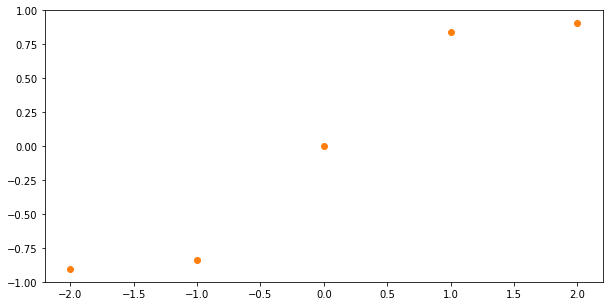

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
lns = [(plt.plot([], [], c=cycle[0], alpha=0.05, animated=True))[0] for _ in range(n_draws)]
target_sct = plt.scatter(xs, ys, c=cycle[1])

In [22]:
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[8], n_hidden_units_g=[8, 8, 8])

tf.reset_default_graph()

sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target,
                                     params, encoder_h, decoder_g, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 5000
plot_freq = 100

x_star = np.linspace(-10, 10, 100)
# (using fixed source of randomness over all iters)
eps_value = np.random.normal(size=(n_draws, params.dim_z))
epsilon = tf.constant(eps_value, dtype=tf.float32)
predict_op = posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)),
        ys.reshape((-1,1)),
        x_star.reshape((-1,1)),
        params, encoder_h, decoder_g, n_draws=n_draws)


pred_ys = []


for i in range(n_iter):
    # Random number of context points
    n_context = random.choice(range(1, n_samples + 1))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target, y_target)
    if i % plot_freq == 0:
        y_star_mat = sess.run(predict_op.mu)
        pred_ys.append(y_star_mat)
    a = sess.run((train_op, loss), feed_dict=feed_dict)


In [23]:

def init_animation():
    ax.set_xlim(-10.5, 10.5)
    ax.set_ylim(-2, 2)
    return lns

def update_animation(frame):
    for i in range(n_draws):
        lns[i].set_data(x_star, frame.T[i,:])
    return lns

anim = animation.FuncAnimation(fig, update_animation, frames=pred_ys, init_func=init_animation, blit=True)
HTML(anim.to_jshtml())

## Experiment 2: training on a class of functions

In [ ]:
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[8], n_hidden_units_g=[32, 32, 32])

tf.reset_default_graph()

sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target, params, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 100000
loss_freq = 1e4

train_xs = []
train_amp = []
train_ys = []
train_phase = []
for i in range(n_iter):
    n_obs = 20
    xs = np.random.uniform(-3, 3, n_obs)
    amp = random.uniform(-2, 2)
    phase = random.uniform(0, np.pi)
    ys = amp * np.sin(xs+phase)
    
    train_xs.append(xs)
    train_amp.append(amp)
    train_ys.append(ys)
    train_phase.append(phase)
    
    n_context = random.choice(range(1, 11))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target, y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if i % loss_freq == 0:
        print("Loss: {:.3f}".format(a[1]))


In [ ]:
np.pi

In [ ]:
n_obs = 5
n_context = 5
xs = np.random.uniform(0, 3, n_obs)
amp = 1
ys = amp * np.sin(xs)

x_star = np.linspace(-3, 3, 100)
y_star = amp * np.sin(x_star)

fig, ax = plt.subplots(1, figsize=(16,4))
for i in range(100):
    y_temp = train_amp[i]*np.sin(x_star+train_phase[i])
    ax.scatter(x_star, y_temp, c=cycle[0], alpha=0.1)
ax.set_xlim((-4.5, 4.5))
ax.set_ylim((-2.5, 2.5))

In [ ]:
def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5)):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)), 
        ys.reshape((-1,1)), 
        x_star.reshape((-1,1)), 
        params, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c=cycle[0], alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c=cycle[1], alpha=.5)
    ax.scatter(xs, ys, c=cycle[1])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,16))
xss = [np.array(xs) for xs in [[0], [0, 1], [-2, -1, 0, 1, 2]]]
yss = [np.sin(xs) for xs in xss]
plot_true = False
ylim=(-0.5, 0.5)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim)
    plot_true = True
    ylim=(-1.5, 1.5)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16,16))
xss = [np.array(xs) for xs in [[0], [0, 1], [-2, -1, 0, 1, 2]]]
yss = [np.sin(xs) for xs in xss]
plot_true = False
ylim=(-0.5, 0.5)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim)
    plot_true = True
    ylim=(-1.5, 1.5)

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,4))
plot_prediction(ax, xs, ys)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
xss = [np.array(xs) for xs in [[0], [0, 1], [-2, -1, 0, 1, 2]]]
yss = [np.sin(xs) for xs in xss]
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys)